In [3]:
import os
root_dir = "python"
_, current_folder = os.path.split(os.getcwd())
if current_folder != root_dir:
    os.chdir("../")

In [6]:
path = os.environ.get("PATH")
min_additional_path = "C:\\Users\\Michi\\Anaconda3\\envs\\python_v3-8\\Library\\bin;C:\\Users\\micha\\anaconda3\\envs\\ai38\\Library\\bin;"
combined_path = min_additional_path + path
os.environ["PATH"] = combined_path

In [64]:
from audio_recording import AudioRecording
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [17]:
participant_ids = os.listdir("data/Coswara_processed/Recordings/")
participant = random.choice(participant_ids)
participant_path = os.path.join("data", "Coswara_processed", "Recordings", participant)
participant_path

'data\\Coswara_processed\\Recordings\\1VNUev5HPMQSq58M1m7RQm5nw2x2'

In [18]:
breath_recording = AudioRecording(participant_path, type_of_recording="breathing-deep")

In [68]:
breath_recording.play_audio(False)

In [22]:
audio, sr = breath_recording.get_audio(processed=False)

In [171]:
n_fft=4096*2
hop_size=2048

In [172]:
stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_size)

In [173]:
stft.shape, len(audio)/hop_size

((4097, 381), 380.0)

In [174]:
len(audio)/sr, sr

(16.213333333333335, 48000)

In [175]:
np.abs(stft).shape

(4097, 381)

In [162]:
frequency_axis = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
max(frequency_axis)

24000.0

In [163]:
df = frequency_axis[1]-frequency_axis[0]
df  #frequency resolution

5.859375

In [164]:
indices = np.array(range(stft.shape[1]))
time_axis = librosa.frames_to_time(indices, sr=sr, hop_length=hop_size)

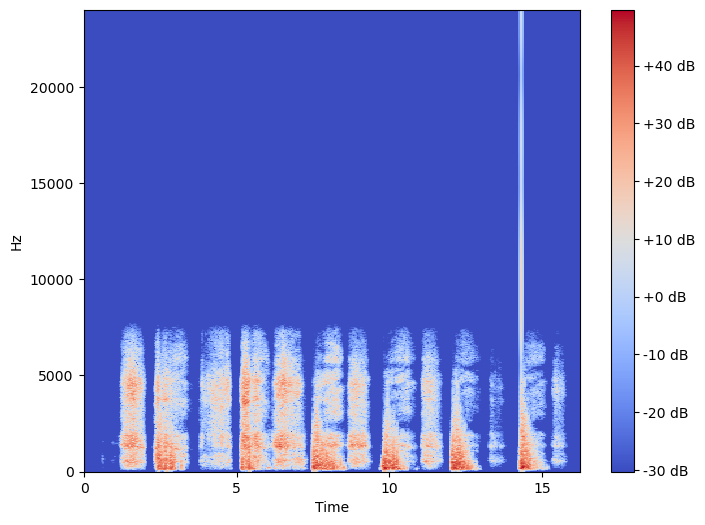

In [165]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)), 
                               x_axis='time', y_axis='linear', ax=ax,
                              hop_length=hop_size, n_fft=n_fft, sr=sr)
fig.colorbar(img, ax=ax, format="%+2.f dB")


In [166]:
plt.rcParams["figure.figsize"] = [8., 6]

In [169]:

n_freq_bins = 8
time_steps = 200
low_frequency_stft = stft[:n_freq_bins, :time_steps]
low_frequency_axis = frequency_axis[:n_freq_bins]
low_time_axis = time_axis[:time_steps]

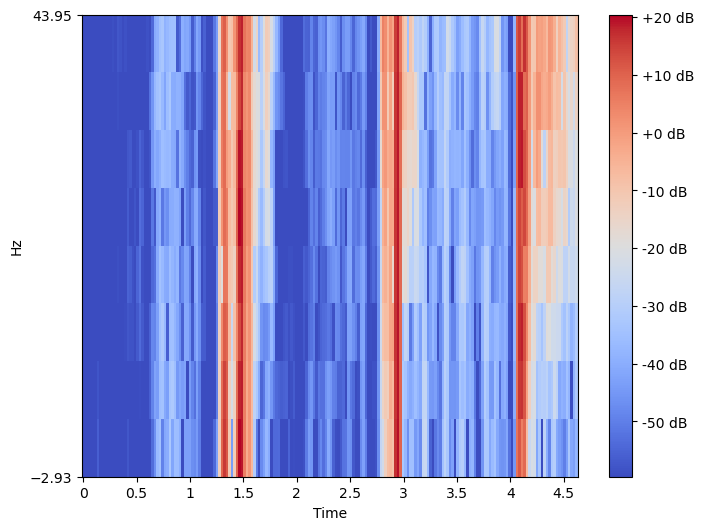

In [170]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(low_frequency_stft)), 
                               x_axis='time', y_axis='log', ax=ax, 
                               y_coords=low_frequency_axis)
fig.colorbar(img, ax=ax, format="%+2.f dB")

# new resnet features (takes 3x224x224)
If i use sr=22050 like before:<br />
256 samples = 12ms<br />
512 samples = 23ms (brogrammers hop size)<br />
1024 samples = 46ms<br />
2048 samples = 96ms (brogrammers n_fft)<br />

## Log-Mel Spectrogram
from 20Hz to 10kHz (sr/2) there are 9 octaves

In [183]:
resnet_input_size = (3, 224, 224)

In [182]:
sr = 22050
for i in range(10):
        sr=sr/2
        print(round(sr))

11025
5512
2756
1378
689
345
172
86
43
22


### for a dimension of 224 in the resnet input we get << 25 >> frequencies per octave:

In [186]:
n_octaves = 9
n_freq_per_octave = resnet_input_size[1] / n_octaves
round(n_freq_per_octave)

25